In [2]:
import pandas as pd
import pickle
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import tlviz
from data.data_utils import process_data, create_basis

### Functional Analysis of NBA Player Career Trajectory 
We are working in a multi-output setting, one where we wish to produce multiple trajectories of player careers across different metrics.
Metrics are either:
1. Gaussian with observed / unobserved response and corresponding observed /unobserved variance terms. (OBPM, DBPM)
2. Poisson with observed / unobserved response and corresponding observed / unobserved exposure terms. (OREB Rate, BLK Rate, STL Rate, AST Rate, etc)
3. Binomial with observed / unobserved response and corresponding observed / unobserved exposure terms. (FT %, 2FG%, 3FG%)

Let the index $J$ denote the metric, $N$ denote the player, and $T$ denote the years 18-39 of player career. Thus, our data is a tensor of size $N x T x J$ with missing entries if player $n$ did not record statistics at time $t$ for metric $j$. This could be due to retirement, injury, etc. 

We seek to model these observations in the following way:

$$ \mu_j = X^T \Phi_j(T) + \alpha_j $$ 

Here, $X$ is a fixed predictor of size $N$ X  $d$ where d << N. $\Phi_j(T)$ corresponds to a functional coefficient for metric $j$, and $\alpha_j$ corresponds to an intercept term. 

Note that since we have different response distributions, we must include the following conditions:
1. If $j$ is a Gaussian distributed response,
$$ y_j \sim N(\mu_j, \frac{\sigma^2_j}{p_j}) $$
2. If $j$ is a Poisson distributed response, 
$$  y_j \sim Pois(p_j exp(\mu_j)) $$
3. If $j$ is a Binomial distributed response,
$$ y_j \sim Bin(p_j, logit(\mu_j)) $$

Here, $p_j$ is the exposure term for the appropriate metric. If $y_j$ is Binomial, $p_j$ represents the number of trials, and so on. Practically, $p_j$ is the number of shot attempts for binomial distributed response, and number of minutes played for other responses. 


It is also important to note that $\Phi_j(T)$ is created by using a HSGP approximation, with 10 truncation limit. These are independent across metrics $j$. 

In [3]:
data = pd.read_csv("data/player_data.csv").query(" age <= 38 ")
data = data.groupby("id").filter(lambda x: x.games.sum() >= 50)

In [5]:
names = data.groupby("id")["name"].first().values

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
agg_dict = {"obpm":"mean", "dbpm":"mean", "bpm":"mean", 
            "minutes":"sum", "dreb": "sum", "fta":"sum", "ftm":"sum", "oreb":"sum",
            "ast":"sum", "tov":"sum", "fg2m":"sum", "fg3m":"sum", "fg3a":"sum", "fg2a":"sum", "blk":"sum", "stl":"sum"}
data["total_minutes"] = data["median_minutes_per_game"] * data["games"] 
agged_data = data.groupby("id").agg(agg_dict).reset_index()
agged_data["ft_pct"] = agged_data["ftm"] / agged_data["fta"]
agged_data["fg2_pct"] = agged_data["fg2m"] / agged_data["fg2a"]
agged_data["fg3_pct"] = agged_data["fg3m"] / agged_data["fg3a"]
agged_data["dreb_rate"] = agged_data["dreb"] / agged_data["minutes"]
agged_data["oreb_rate"] = agged_data["oreb"] / agged_data["minutes"]
agged_data["ast_rate"] = agged_data["ast"] / agged_data["minutes"]
agged_data["tov_rate"] = agged_data["tov"] / agged_data["minutes"]
agged_data["blk_rate"] = agged_data["blk"] / agged_data["minutes"]
agged_data["stl_rate"] = agged_data["stl"] / agged_data["minutes"]
agged_data.fillna(0, inplace=True)

latent_metrics = ["obpm","dbpm","minutes","ft_pct","fg2_pct","fg3_pct","dreb_rate","oreb_rate","ast_rate","tov_rate","blk_rate","stl_rate"]
X = StandardScaler().fit_transform(agged_data[latent_metrics])
pca_x = PCA().fit(X)
X_pca = pca_x.transform(X)


Text(0, 0.5, 'PCA Loading for PC 1')

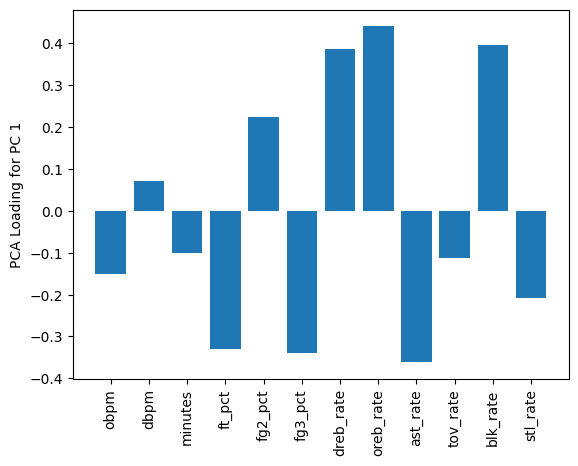

In [7]:

plt.bar(latent_metrics, height=pca_x.components_[0,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 1")

Text(0, 0.5, 'PCA Loading for PC 1')

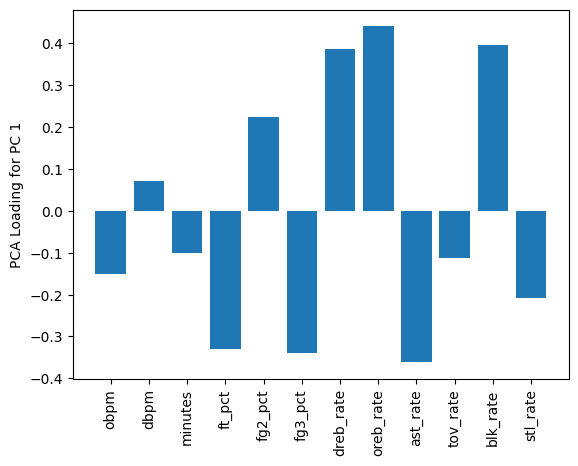

In [8]:

plt.bar(latent_metrics, height=pca_x.components_[0,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 1")

Text(0, 0.5, 'PCA Loading for PC 2')

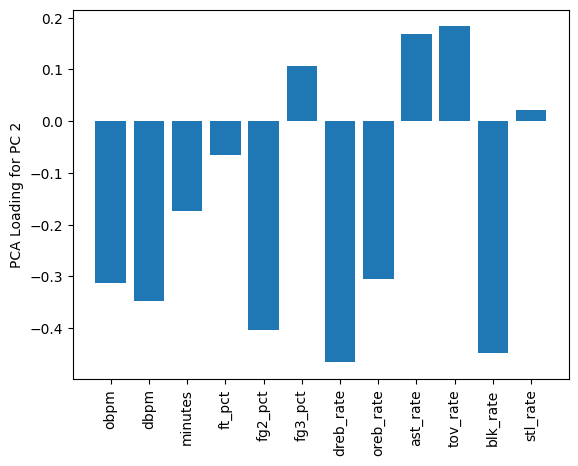

In [112]:

plt.bar(latent_metrics, height=pca_x.components_[1,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 2")

Text(0, 0.5, 'PCA Loading for PC 3')

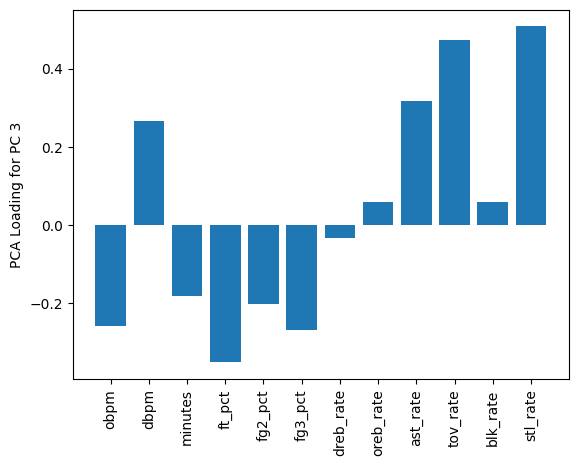

In [9]:
plt.bar(latent_metrics, height=pca_x.components_[2,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 3")

In [10]:
star_indices = np.where(data.groupby("id")["name"].first().reset_index()["name"].isin(["Stephen Curry", "Nikola Jokic", "Kevin Durant", "Kobe Bryant", "Luka Doncic", "Michael Jordan"]))[0]

In [14]:
# Step 2: Calculate distances
centroid = np.mean(X_pca[:,0:3], axis=0)
distances = np.linalg.norm(X_pca[:, 0:3] - centroid, axis=1)

# Step 3: Define Threshold
# Example: Threshold as 2 standard deviations from the mean distance
threshold = np.mean(distances) + 2.5 * np.std(distances)

# Step 4: Label Outliers
outliers_indices = np.where(distances > threshold)[0]

Text(0, 0.5, 'PC 2')

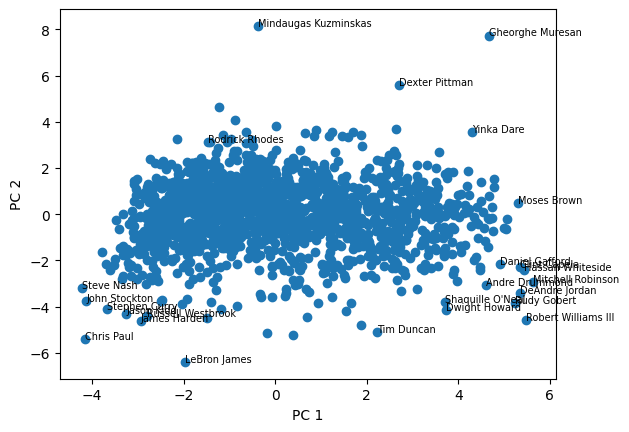

In [15]:
plt.scatter(X_pca[:,0], X_pca[:,1])
# Annotate outliers
for i in outliers_indices:
    plt.annotate(names[i], (X_pca[i, 0], X_pca[i, 1]), fontsize=7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

Text(0, 0.5, 'PC 3')

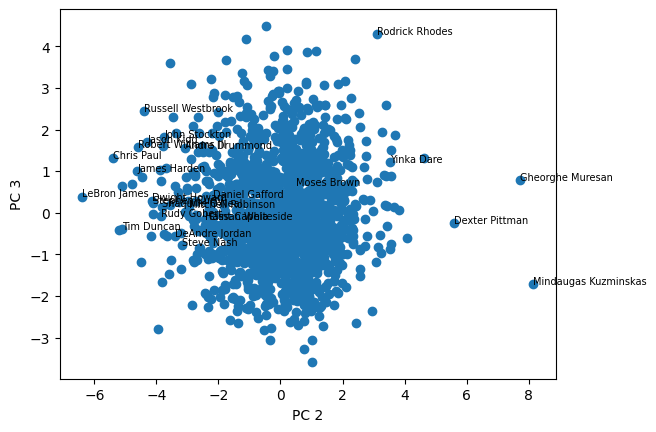

In [16]:
plt.scatter(X_pca[:,1], X_pca[:,2])
# Annotate outliers
for i in outliers_indices:
    plt.annotate(names[i], (X_pca[i, 1], X_pca[i, 2]), fontsize=7)
plt.xlabel("PC 2")
plt.ylabel("PC 3")

### Looking at Results
The above model was fit in numpyro with 1000 warmup iterations and 4 chains. 

In [33]:
with open("model_output/nba_fda_model.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [34]:
inference_data = az.from_dict(results)

In [35]:
az.summary(inference_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],11.494,0.620,10.333,12.645,0.064,0.046,94.0,175.0,1.05
alpha[1],10.697,0.580,9.621,11.777,0.048,0.034,144.0,200.0,1.02
alpha[2],9.486,0.585,8.442,10.583,0.073,0.052,66.0,138.0,1.07
"basis[0, 0, 0]",-13.878,0.562,-14.904,-12.819,0.032,0.023,306.0,598.0,1.01
"basis[0, 0, 1]",-36.726,1.153,-39.048,-34.737,0.090,0.064,166.0,316.0,1.01
...,...,...,...,...,...,...,...,...,...
length[1],9.614,0.472,8.788,10.481,0.064,0.046,55.0,129.0,1.08
length[2],7.538,0.459,6.739,8.404,0.052,0.037,78.0,262.0,1.04
sigma_dbpm,5.823,0.036,5.755,5.889,0.003,0.002,177.0,391.0,1.01
sigma_log_min,1.124,0.007,1.110,1.137,0.001,0.000,142.0,229.0,1.02


array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'length'}>]], dtype=object)

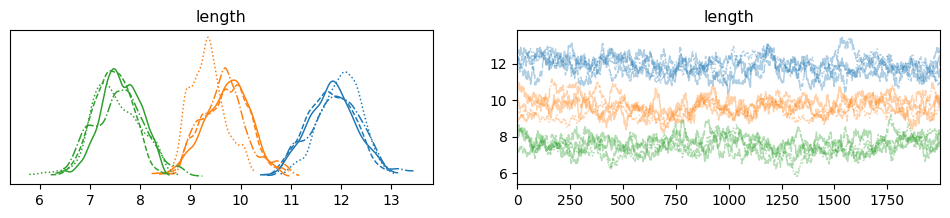

In [36]:
az.plot_trace(inference_data, var_names="length")

### Functional Analysis of NBA Player Career Trajectory (Latent Variable Model)
We do the same as we did in the previous section, except $X$ is not fixed. We constrain $X$ to be orthonormal by sampling $X$ from the Stiefel Manifold. 

### Looking at Latent Model Results

In [37]:
with open("model_output/nba_fda_latent_model.pkl", "rb") as f:
    latent_results = pickle.load(f)
f.close()

In [38]:
latent_raw = latent_results["latent_raw"]

In [39]:
latent_raw_square = np.einsum("cdjk,cdjb -> cdkb", latent_raw, latent_raw)

In [40]:
U, L, V = np.linalg.svd(latent_raw_square)

In [41]:
latent = np.matmul(latent_raw, np.matmul(U * np.power(L[...,None], -.5), V))

In [42]:
latent_results["latent"] = latent

In [43]:
inference_data_latent = az.from_dict(latent_results)

In [44]:
az.summary(inference_data_latent)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],20.990,6.052,13.992,28.617,3.005,2.300,5.0,18.0,2.15
alpha[1],30.360,2.439,26.882,35.015,1.173,0.895,5.0,17.0,2.33
alpha[2],21.670,7.201,13.755,32.101,3.581,2.741,5.0,19.0,2.14
"basis[0, 0, 0]",17.315,16.156,-6.941,44.706,7.986,6.107,4.0,15.0,3.11
"basis[0, 0, 1]",20.317,5.845,8.944,31.029,2.369,1.763,6.0,16.0,1.68
...,...,...,...,...,...,...,...,...,...
length[1],6.722,0.762,5.481,7.888,0.372,0.283,5.0,19.0,2.83
length[2],7.460,2.403,4.028,10.394,1.186,0.907,5.0,27.0,2.17
sigma_dbpm,6.878,0.046,6.794,6.967,0.002,0.002,350.0,4997.0,1.01
sigma_log_min,1.216,0.019,1.190,1.254,0.009,0.006,7.0,29.0,1.53


One thing to note is the poor diagnostic results here, indicating that the chains have not mixed properly. One thing to do would be to look at the trace-plots of some of these variables. In particular, we can look at the first element of the basis variable. The reason for this may be due to factor identifiability issues, since rotations of $X$ and the basis functions can yield equivalent posteriors. 

array([[<Axes: title={'center': 'basis'}>,
        <Axes: title={'center': 'basis'}>]], dtype=object)

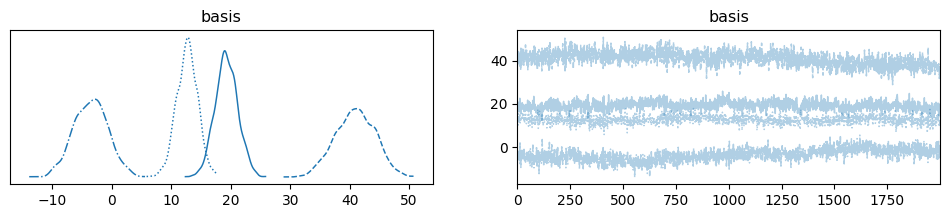

In [45]:
az.plot_trace(inference_data_latent, var_names="basis", coords={"basis_dim_0":0, "basis_dim_1":0, "basis_dim_2":0})

As we can see, we see clearly that the chains have not mixed at all. The posterior is quite multi-modal in this regard. One thing that would be interesting to check would be to also look at the variable $X$. We need to transform the variable, to run the appropriate statistics. 

array([[<Axes: title={'center': 'latent'}>,
        <Axes: title={'center': 'latent'}>]], dtype=object)

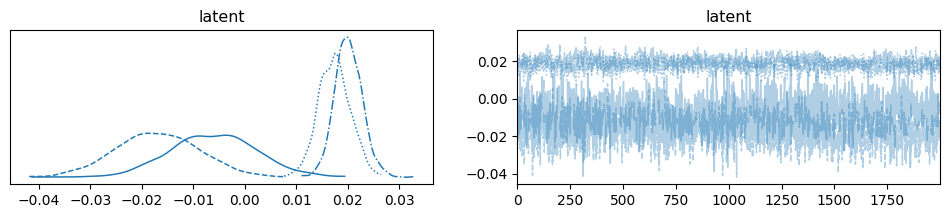

In [46]:
az.plot_trace(inference_data_latent, var_names="latent", coords={"latent_dim_0":0, "latent_dim_1":0})

Again, we kind of see that there is multi-modality in the posterior of the latent space, essentially 2 chains that may or may not be equivalent in terms of the posterior likelihood.

array([[<Axes: title={'center': 'latent'}>,
        <Axes: title={'center': 'latent'}>]], dtype=object)

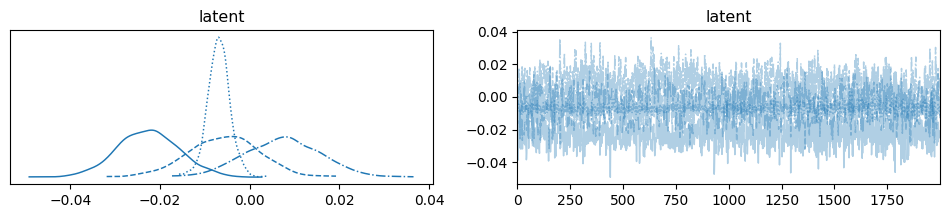

In [47]:
az.plot_trace(inference_data_latent, var_names="latent", coords={"latent_dim_0":0, "latent_dim_1":2})

array([[<Axes: title={'center': 'latent_raw'}>,
        <Axes: title={'center': 'latent_raw'}>]], dtype=object)

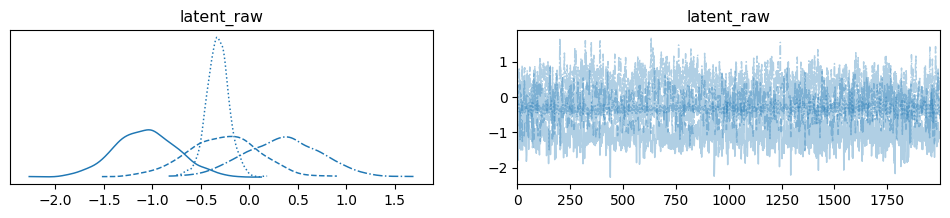

In [48]:
az.plot_trace(inference_data_latent, var_names="latent_raw", coords={"latent_raw_dim_0":0, "latent_raw_dim_1":2})

### Visualizing Latent Space

Here, we can visualize the latent space of one chain and see if there is any interesting separation. Previously in the PCA, we didn't see any interesting information. Although the chains may not have mixed, we can still examine the latent space from one chain to see if there are any interesting behaviors. 

In [135]:
latent_draw = latent[-4,-1, :, :]

Text(0, 0.5, 'Latent 2')

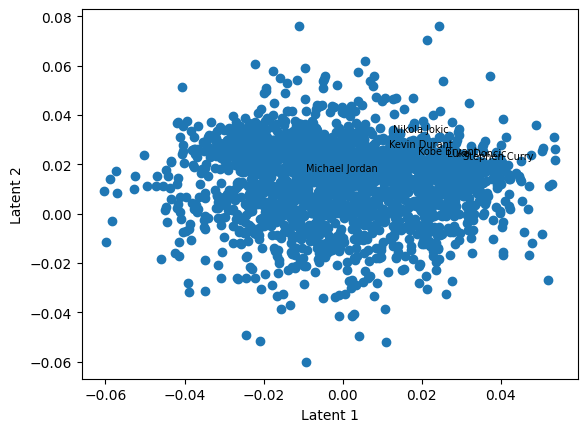

In [136]:
plt.scatter(latent_draw[:,0], latent_draw[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (latent_draw[i, 0], latent_draw[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

Text(0, 0.5, 'Latent 3')

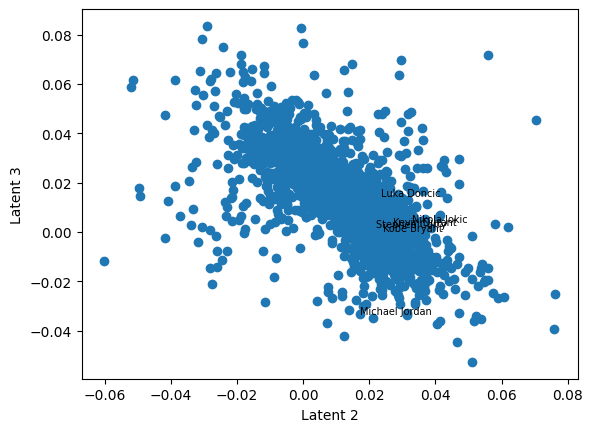

In [137]:
plt.scatter(latent_draw[:,1], latent_draw[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (latent_draw[i, 1], latent_draw[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")